In [2]:
import os
import json
import sys

from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms, datasets

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# 定义模型

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        # 一般复杂的卷积神经网络我们一把分模块, 分成提取特征部分, 叫做features, 即特征层.
        # 分类网络部分(神经网络), 我们叫做classifier.
        self.features = nn.Sequential(
                nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),

                nn.Conv2d(48, 128, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),

                nn.Conv2d(128, 192, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),

                nn.Conv2d(192, 192, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),

                nn.Conv2d(192, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2) # output [128, 6, 6]
        )


        self.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(128 * 6 * 6, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
                nn.Linear(2048, 2048),
                nn.ReLU(inplace=True),
                nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

# 定义训练模型

In [4]:
def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'using {device}')

    image_path = os.path.join('./', 'flower_data')
    # print(image_path)
    assert os.path.exists(image_path), "image path does not exist"

    data_transform = {
            'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            'val': transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    }

    # 创建训练dataset
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, 'train'),
                         transform=data_transform['train'])
    train_num = len(train_dataset)
    flower_list = train_dataset.class_to_idx
    print(flower_list)
    cla_dict = dict((val, key) for key, val in flower_list.items())
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print(f'using {nw} dataloader workers every process')
    # 把dataset变成dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=batch_size, shuffle=True,
                                num_workers=nw)

    # images, labels = next(iter(train_loader))
    # print(labels.numpy())
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, 'val'),
                                            transform=data_transform['val'])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=nw)

    net = AlexNet(num_classes=5)

    net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)

    epochs = 10
    save_path = './AlexNet.pth'
    best_acc = 0.0
    train_step = len(train_loader)

    # 训练过程
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0

        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_fn(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.desc = f'train epoch {epoch + 1}/ {epochs} loss: {loss:.3f}'

        # 校验过程
        net.eval()
        acc = 0.0
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accuracy = acc / val_num
        print(f'[epoch {epoch + 1}] train_loss: {running_loss / train_step:.3f}, val_accuracy:{val_accuracy:.3f}')
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(net.state_dict(), save_path)

In [6]:
if __name__ == '__main__':
    main()

using cpu
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
using 8 dataloader workers every process
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.15it/s]
[epoch 1] train_loss: 1.426, val_accuracy:0.462
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.08it/s]
[epoch 2] train_loss: 1.188, val_accuracy:0.522
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.43it/s]
[epoch 3] train_loss: 1.118, val_accuracy:0.585
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.22it/s]
[epoch 4] train_loss: 1.050, val_accuracy:0.610
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.91it/s]
[epoch 5] train_loss: 1.007, val_accuracy:0.646
100%|█████████████████████████████████

# 预测

In [7]:
def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    img_path = './4.jpeg'
    assert os.path.exists(img_path), f'{img_path} does not exist'
    img = Image.open(img_path)
    plt.imshow(img)
    img = data_transform(img)
    # print(img.shape)
    img = torch.unsqueeze(img, dim=0)
    # print(img.shape)
    json_path = './class_indices.json'
    assert os.path.exists(json_path), f'file {json_path} does not exist'
    with open(json_path, 'r') as f:
        class_dict = json.load(f)
    # print(class_dict)

    model = AlexNet(num_classes=5).to(device)
    weights_path = './AlexNet.pth'
    assert os.path.exists(weights_path), f'file {weights_path} does not exist'
    model.load_state_dict(torch.load(weights_path))

    model.eval()
    with torch.no_grad():
        output = model(img.to(device))
        # print(output)
        output = torch.squeeze(output).cpu()
        predict = torch.softmax(output, dim=0)
        predict_class = torch.argmax(predict).numpy()

    print_res = f"class: {class_dict[str(predict_class)]}, prob: {predict[predict_class].numpy():.3f}"
    plt.title(print_res)
    plt.show()


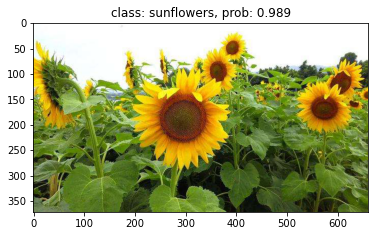

In [12]:
if __name__ == '__main__':
    main()